Shannon Moran <br>
Phys 514 <br>
HW 6<br>
Due: Oct 26

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import time
import random

## Initialize Ising lattice

Set the initial configuration to a random lattice.

In [2]:
def init_lattice(L,p=0.5):
    random_lattice = np.random.random((L,L))
    lattice = (random_lattice<=p)*1
    np.place(lattice,lattice==0,-1)
    return lattice

## Simulate the Ising model using Monte Carlo

Simulate the Ising model,

$$ H = -J\sum_{\langle i,j \rangle}S_iS_j$$

on a square lattice in two dimensions using Metropolis Monte Carlo with single spin flip updates.

### Monte Carlo helper calculations

In [3]:
# Calculate nn spin interactions, taking PBC into account
def nn_spin(spins):
    # Divide by two to avoid double-counting spins
    neighbors = np.copy(spins*(np.roll(spins,+1,axis=1)+np.roll(spins,+1,axis=0)
                               +np.roll(spins,-1,axis=1)+np.roll(spins,-1,axis=0))/2)
    return neighbors


# Calculate binder cumulant
def binder_cumulant(M,E,beta):
    M4 = np.average(np.power(M,4))
    M2 = np.average(np.power(M,2))**2
    return 1-M4/(3*M2)

### Monte Carlo method execution

In [4]:
# Execute single spin flip
def spin_flip(configuration):
    positions = np.arange(configuration.shape[0])
    flip_i = random.choice(positions)
    flip_j = random.choice(positions)
    flipped = np.copy(configuration)
    flipped[flip_i][flip_j] *= -1
    return flipped


# Execute single MC step
def MC_step(config_old,J,beta,status='run'):
    global moves
    config_new = np.copy(spin_flip(config_old))
    E_old = -J*np.sum(nn_spin(config_old))
    E_new = -J*np.sum(nn_spin(config_new))
    E_del = E_new - E_old
    if E_del<0: config = np.copy(config_new); E=E_new
    else:
        p = np.exp(-beta*E_del)
        r = random.random()
        if r<p: config = np.copy(config_new); E=E_new; moves+=1
        else: config = np.copy(config_old); E=E_old
    M = (np.sum(config)/config.shape[0]**2)**2
    if status=="init": return config
    else: return config,E,M 
    

# Execute MC_simulation for specified number of steps
def MC_simulate(lattice,N_run,J,beta,show=False):
    global moves
    E = []
    M = []
    L = lattice.shape[0]
    step = 0
    moves = 0
    while step<N_run:
        step+=1
        lattice,Ei,Mi = np.copy(MC_step(lattice,J,beta))
        E.append(Ei)
        M.append(Mi)
    # Calculate properties
    T = 1/beta
    E = np.asarray(E)
    M = np.asarray(M)
    properties = {
        'E': E,
        'M': M,
        'S': (np.average(np.power(M/L**2,2))-np.average(M/L**2)**2)/T,
        'C': (np.average(np.power(E,2))-np.average(E)**2)/T**2,
        'U': binder_cumulant(M,E,beta),
    }
    if show==True:
        plt.title("Temperature: %s"%T)
        plt.imshow(lattice,cmap='nipy_spectral',interpolation="none")
        plt.colorbar()
        plt.show()
    else:pass
    return lattice,properties

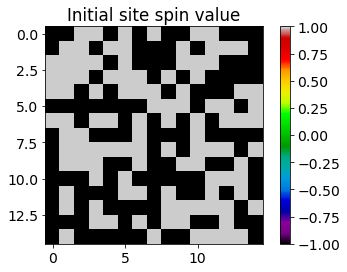

In [10]:
# Validate spin initialization
L = int(15)
lattice0 = np.copy(init_lattice(L))
plt.imshow(lattice0,cmap='nipy_spectral',interpolation="none")
plt.title('Initial site spin value')
plt.colorbar()
plt.show()

Move acceptance @ T = 0.5: 0.0157
Move acceptance @ T = 2.25: 0.126
Move acceptance @ T = 5.0: 0.5078666666666667


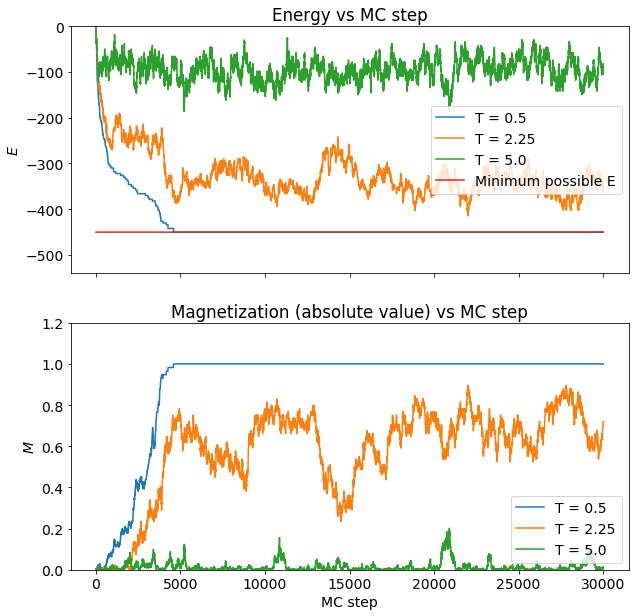

In [11]:
# Set simulation parameters
moves = 0
N_init = 0
N_run = int(3e4)
MC_steps = np.arange(N_run)

# T is in units J/kB
J = 1
T_range = np.asarray([0.5, 2.25, 5.0])

# Run MC simulations over range of temperatures
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,10))
for T in T_range:
    _,props = np.copy(MC_simulate(lattice0,N_run,J,1/T,show=False))
    ax1.plot(MC_steps,props['E'],label='T = %s' %T)
    ax2.plot(MC_steps,props['M'],label='T = %s' %T)
    print('Move acceptance @ T = %s: %s'%(T,moves/N_run))
    
# Consolidate plots of results.
E_min = int(-lattice0.shape[0]**2*2*J)
ax1.plot(MC_steps,E_min*np.ones(N_run),label='Minimum possible E')
ax1.set_title('Energy vs MC step')
ax1.set_ylim([E_min*1.2, 0])
ax1.set_ylabel(r'$E$')
ax1.legend(loc=0)
ax2.set_title('Magnetization (absolute value) vs MC step')
ax2.set_ylim([0, 1.2])
ax2.set_ylabel(r'$M$')
ax2.set_xlabel('MC step')
ax2.legend(loc=0)
plt.show()

For a lattice of size L = 15, the low temperature (T=0.5) system thermalizes in ~5,000 MC steps. The transition-range temperature (T=2.25) does not thermalize in the time of the simulation, continuing to fluctuate at a non-zero average magnetization. The high temperature (T=5.0) also continues to fluctuate, but at a zero average magnetization.

## Compute system properties versus T

Compute the expectation values of the absolute value of the magnetization, magnetic susceptibility, the energy, and the specific heat as a function of temperature.

The expectation value of a quantity $A$ at a finite temperature $T$ is given by a sum over all states in the simulation:
$$ \langle A \rangle = \frac{1}{Z}\sum_i A_i exp(\beta E_i) $$

where $\beta=1/kT$, $A_i$ is the value of the quantity $A$ in the configuration $i$ with energy $E_i$.

The partition function is given by:
$$ Z = \sum_i exp(-\beta E_i) $$

This normalizes the probabilities $p_i=exp(\beta E_i)/Z$.

In [7]:
N_therm = int(3e4)
N_run = int(3e4)

# We keep this lattice size fairly small so that we thermalize more quickly
L = int(10)
lattice0 = np.copy(init_lattice(L))
T_range = np.linspace(1.0,4.0,10)

reps = 3
U_reps = np.copy(np.zeros((reps,len(T_range))))
M_reps = np.copy(np.zeros((reps,len(T_range))))
S_reps = np.copy(np.zeros((reps,len(T_range))))
C_reps = np.copy(np.zeros((reps,len(T_range))))

for rep in range(reps):
    U = []
    M = []
    S = []
    C = []
    for T in T_range:
        properties = {}    
        lattice,_ = np.copy(MC_simulate(lattice0,N_therm,J,1/T))
        _,properties = np.copy(MC_simulate(lattice,N_run,J,1/T))
        U.append(properties['U'])
        M.append(np.average(np.asarray(properties['M'])))
        S.append(properties['S'])
        C.append(properties['C'])
    U_reps[rep][:] = U
    M_reps[rep][:] = M
    S_reps[rep][:] = S
    C_reps[rep][:] = C
    
# Calculate average value over reps
U_avg = np.copy(np.average(np.asarray(U_reps),axis=0))
M_avg = np.copy(np.average(np.asarray(M_reps),axis=0))
S_avg = np.copy(np.average(np.asarray(S_reps),axis=0))
C_avg = np.copy(np.average(np.asarray(C_reps),axis=0))

# Calculate error over reps (should be ~0 if thermalized well)
U_error = np.copy(np.std(np.asarray(U_reps),axis=0))
M_error = np.copy(np.std(np.asarray(M_reps),axis=0))
S_error = np.copy(np.std(np.asarray(S_reps),axis=0))
C_error = np.copy(np.std(np.asarray(C_reps),axis=0))

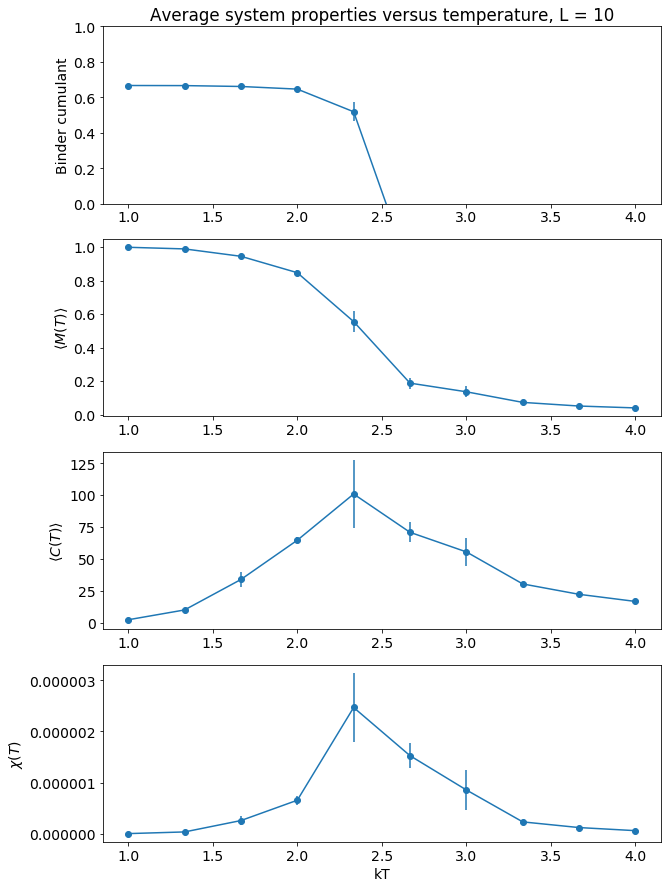

In [8]:
# Plot results
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False,figsize=(10,15))
ax1.errorbar(T_range,U_avg,U_error,None,'o-')
ax1.set_title('Average system properties versus temperature, L = %s'%L)
ax1.set_ylabel('Binder cumulant')
ax1.set_ylim([0,1.0])
ax2.errorbar(T_range,M_avg,M_error,None,'o-')
ax2.set_ylabel(r'$\langle M(T) \rangle$')
ax1.set_ylim([0,1.0])
ax3.errorbar(T_range,C_avg,C_error,None,'o-')
ax3.set_ylabel(R'$\langle C(T) \rangle$')
ax4.errorbar(T_range,S_avg,S_error,None,'o-')
ax4.set_ylabel(r'$\chi(T)$')
ax4.set_xlabel('kT')
plt.show()

Both $\chi(T)$ and $\langle C(T)\rangle$ have peaks (a discontinuity, in the case of $\chi$) at the critical temperature. This suggests that the critical temperature will fall somewhere between 2.0 and 2.5.

The $\langle M(T) \rangle$ should also go to 0 right at the critical temperature, but instead it appears to gradually go to zero. This could be because I start sampling before the system is completely thermalized.

## Find phase transition locations

Find the approximate location of the phase transition on small lattices.

To do this, we'll calculate the Binder cumulant for different lattice sizes and look for where the values cross-- this should give us the approximate $T_C$.

L: 5 [ 0.66645352  0.66474298  0.65914771  0.64150966  0.58205072  0.4916384
  0.31222313  0.0730024 ]
L: 9 [ 0.6665679   0.66601123  0.66324159  0.65328563  0.60975217  0.37284404
 -0.22416409 -0.48553585]
L: 13 [ 0.66662615  0.66636753  0.66473976  0.65926688  0.61510654 -0.11638251
 -0.90507238 -0.82555863]


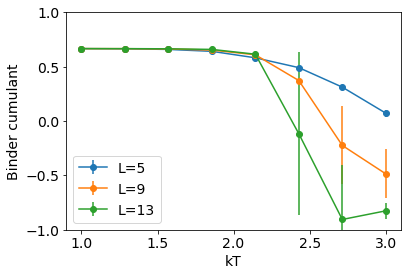

In [9]:
# We thermalize and run these systems longer to get better statistics near the critical T
N_therm = int(5e4)
N_run = int(5e4)

# Test a range of small lattices
L_range = np.linspace(5,13,3,dtype=np.int16)
T_range = np.linspace(1.0,3.0,8)
reps = 3
for L in L_range:
    lattice1 = np.copy(init_lattice(L))
    U_reps = np.copy(np.zeros((reps,len(T_range))))
    for rep in range(reps):
        U = []
        for T in T_range:
            lattice,_ = np.copy(MC_simulate(lattice1,N_therm,J,1/T))
            _,properties = np.copy(MC_simulate(lattice,N_run,J,1/T))
            U.append(properties['U'])
        U_reps[rep][:] = U
    U_avg = np.copy(np.average(U_reps,axis=0))
    print('L:',L,U_avg)
    U_error = np.copy(np.std(np.asarray(U_reps),axis=0))
    plt.errorbar(T_range,U_avg,U_error,None,'o-',label='L=%s'%L,)

plt.ylim([-1.0,1.0])
plt.ylabel('Binder cumulant')
plt.xlabel('kT')
plt.legend() 
plt.show()

We can check for the values crossing visually-- it appears that this value is ~2.25. The analytical solution for the 2D Ising model is approximately ~2.27, so this agrees nicely!